# Projet M1 

Réalisé par :
* Jean Le Bellego
* Simon Lecoq

#### Initialisation et dépendances 
Le premier bloc permet de désactiver le scrolling automatique et le second charge les bibliothèques nécessaires.

**Nota Bene** : Afin de rendre ce document plus clair, certaines portions de codes peuvent être masquées. Cliquez sur les boutons ci-dessous pour afficher ou masquer le code.

In [1]:
#!masquer
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.io.wavfile as sw
import math
from scipy import signal
from scipy.signal import butter, lfilter
from operator import add

In [2]:
%%html
<script>
//!masquer
IPython.OutputArea.prototype._should_scroll = lines => { return false }
function show_code() { $('div.input').show() }   
function hide_code() { $("div.input").each((i, input) => /!masquer/i.test($(input).text()) ? $(input).hide() : $(input).show()) }                 
</script>
<form action="javascript:show_code()" style="float:left"><input type="submit" style="width:200px;padding:4px;border-radius:5px;margin:10px" value="Forcer l'affichage du code"></form>
<form action="javascript:hide_code()" style="float:left"><input type="submit" style="width:200px;padding:4px;border-radius:5px;margin:10px" value="Masquer les codes"></form>

# Fichier audio

La source du fichier audio qui sera utilisée par le reste du programme peut être configurée dans la cellule ci-dessous.

In [3]:
# Source
file = "src/test2.wav"

#### Spectre d'amplitude

Il représente l'amplitude relative des impulsions sonores (en ordonnée) selon le temps (en abscisse).

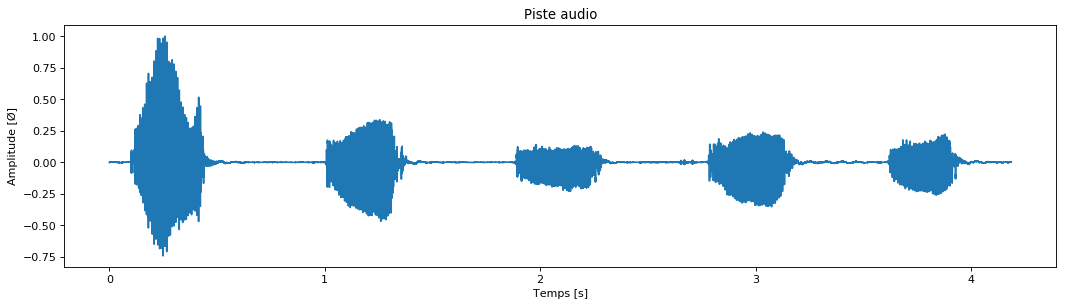

In [4]:
#!masquer

# Lecture du fichier audio
fs, y = sw.read(file)
yn = y/max(y)

# Nombre d'échantillons et échelle temporelle
N = len(y)
t = np.linspace(0, N/fs, N)

# Affichage du spectre d'amplitude
plt.figure(figsize=(16, 4), dpi= 80, facecolor="w", edgecolor="k")
plt.title("Piste audio")
plt.xlabel("Temps [s]")
plt.ylabel("Amplitude [Ø]")
plt.plot(t, yn)
plt.show()

#### Spectrogramme

Il représente la densité spectrale de puissance (par nuances de couleurs) par fréquence (en ordonnée) selon le temps (en abscisse). Les couleurs chaudes indiquent une forte énergie tandis que les couleurs froides en montrent l'absence.

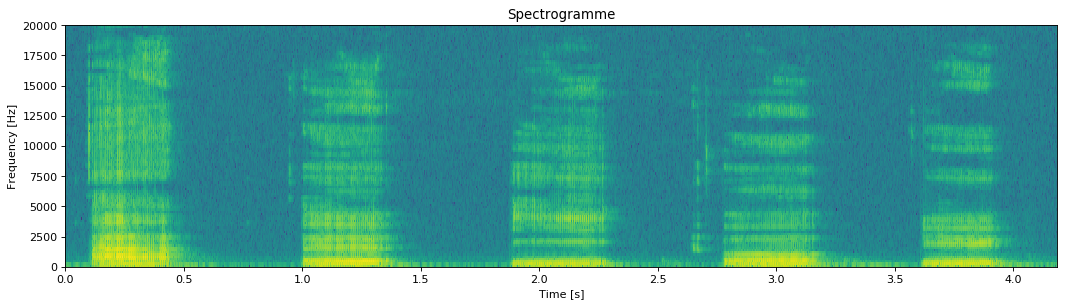

In [5]:
#!masquer

# Affichage du spectrogramme
plt.figure(figsize=(16, 4), dpi= 80, facecolor="w", edgecolor="k")
plt.title("Spectrogramme")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.specgram(y, Fs=fs)
plt.ylim([0, 20000])
plt.show()

# Banque de filtres

Ci-dessous peuvent être configurés les différents paramètres de la banque de filtres, tels que le nombre de filtres à utiliser et sa plage de fréquence, ainsi que l'ordre et le facteur de qualité de chaque filtre.

Il est aussi possible de configurer les spectrogrammes en modifiant la valeur de saturation de la densité spectrale de puissance ainsi que le seuil d'activité des filtres ainsi que la résolution temporelle.

In [6]:
# Nombre de filtres
nb_filters = 16
# Fréquence minimal
fmin = 300
# Fréquence maximal
fmax = 3000

# Ordre des filtres
n = 3
# Facteur de qualité
q = 3

# Valeur de saturation de la densité spectrale de puissance  
psd_max = 0.000000000001
# Résolution temporelle des spectrogramme (entre 0 et 1 exclu, sinon le pc va mourir))
time_res = 0.5

# Nombre de bits à utiliser pour pour stocker l'amplitude d'energie
amp_res = 2

#### Génération de la banque de filtres
Une étape intermédiaire qui consiste à générer les différents filtres de la banque en fonction des paramètres ci-dessus.

In [7]:
#!masquer
# Passe-bande (butterworth)
#
# La fonction ci-dessous permet de générer un filtre passe-bande.
# - fc : Fréquence centrale
# - q : Facteur de qualité
# - n : Ordre du filtre
# - fs : Fréquence d'échantillonage (celle-ci est normalement définie automatiquement par le fichier audio chargé)
#
# Et retourne les composantes suivantes :
# - filter : Filtre de Butterworth avec les caractéristiques indiquées
# - fc : Fréquence centrale
# - fl : Fréquence de coupure (basse)
# - fh : Fréquence de coupure (haute)
def bandpass(fc, q, n, fs):
    # Calcul de la bande passante grâce au facteur de qualité
    df = fc / q
    # Calcul de la fréquence de Nyquist
    nyq = fs / 2
    # Détermination des fréquences de coupures basses et hautes
    fl = (fc - df/2)
    fh = (fc + df/2)
    #
    print("Fc : {fc: >4}Hz  ({fl: >4}Hz - {fh: >4}Hz)".format(fc=round(fc), fl=round(fl), fh=round(fh)))
    # Création du filtre de butterworth    
    return butter(N=n, Wn=[fl/nyq, fh/nyq], btype="band"), fc, fl, fh

In [8]:
#!masquer

# Banque des filtres
filters = []
filters_fq = []

# Calcul du pas
step = round((fmax-fmin)/nb_filters)

# Génération des filtres
for fc in range(fmin, fmax, step):
    bp, fc, fl, fh = bandpass(fc, q, n, fs)
    filters.append(bp)
    filters_fq.append({"fc":fc, "fl":fl, "fh":fh})

Fc :  300Hz  ( 250Hz -  350Hz)
Fc :  469Hz  ( 391Hz -  547Hz)
Fc :  638Hz  ( 532Hz -  744Hz)
Fc :  807Hz  ( 672Hz -  942Hz)
Fc :  976Hz  ( 813Hz - 1139Hz)
Fc : 1145Hz  ( 954Hz - 1336Hz)
Fc : 1314Hz  (1095Hz - 1533Hz)
Fc : 1483Hz  (1236Hz - 1730Hz)
Fc : 1652Hz  (1377Hz - 1927Hz)
Fc : 1821Hz  (1518Hz - 2124Hz)
Fc : 1990Hz  (1658Hz - 2322Hz)
Fc : 2159Hz  (1799Hz - 2519Hz)
Fc : 2328Hz  (1940Hz - 2716Hz)
Fc : 2497Hz  (2081Hz - 2913Hz)
Fc : 2666Hz  (2222Hz - 3110Hz)
Fc : 2835Hz  (2362Hz - 3308Hz)


#### Réponse fréquentielle de la banque de filtres

Le passage ci-dessous affiche les réponses fréquentielle de chaque filtre de la banque sur la plage des sons audibles par l'oreille humaine.

C:\ProgramUser\Anaconda\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


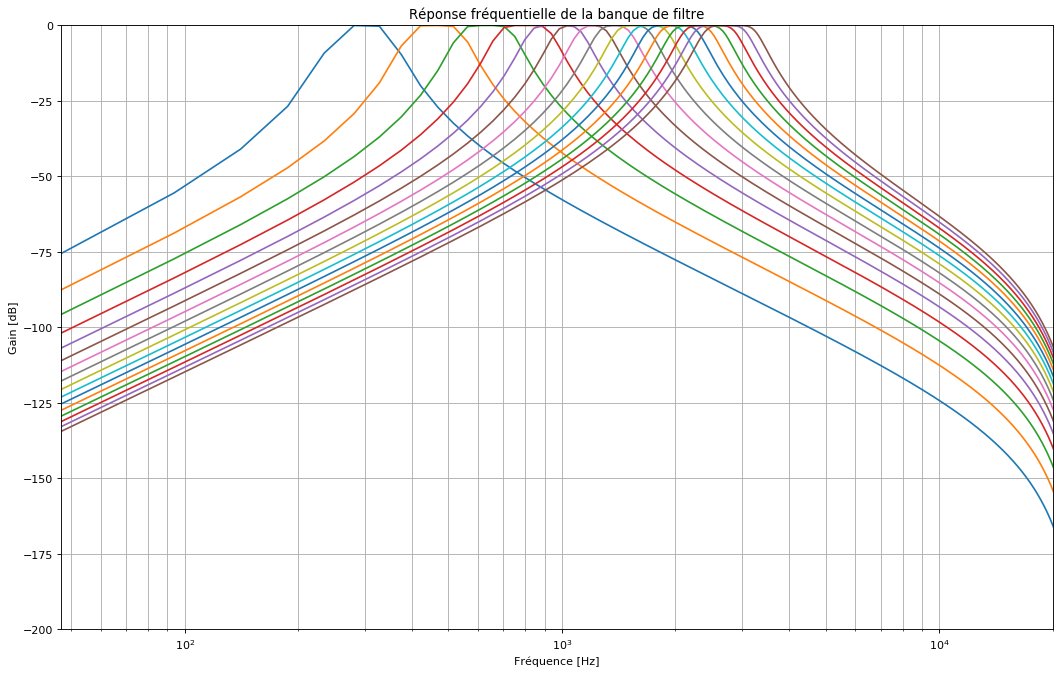

In [9]:
#!masquer

# Préparation de l'affichage
plt.figure(figsize=(16, 10), dpi= 80, facecolor="w", edgecolor="k")

# Affichage des filtres
for i in range(len(filters)):
    # Calcul de la réponse fréquentielle du filtre
    b, a = filters[i]
    w, h = signal.freqz(b, a)
    # Affichage
    plt.semilogx((fs/(2*np.pi))*w, 20 * np.log10(abs(h)));

# Données d'affichage
plt.title("Réponse fréquentielle de la banque de filtre")
plt.xlabel("Fréquence [Hz]")
plt.ylabel("Gain [dB]")
plt.xlim([0, 20000])
plt.ylim([-200, 0])
plt.grid(which="both", axis="both")
plt.show()

#### Application de la banque de filtres

Une étape intermédiaire qui consiste à appliquer les différents filtres sur le signal d'entrée.

In [10]:
#! masquer

# Signaux filtrés
filtered = []
t = np.linspace(0, N/fs, N)
# Application de la banque de filtres
for i in range(len(filters)):
    # Calcul de la réponse
    b, a = filters[i]
    filtered.append(lfilter(b, a, y))

# Etude des signaux en sortie de la banque
Cette partie affiche le signal audio en sortie, le spectrogramme associé ainsi que les états après chaque application respective des filtres de la banque.

In [11]:
#!masquer

# Préparation des figures
f, ax = plt.subplots(1, 2, figsize=(16, 4), dpi= 80, facecolor="w", edgecolor="k")

In [12]:
# NFFT permet de modifier la résolution fréquentielle. 
NFFT = 2**int(math.log(fs, 2)-2)

# Préparation du spectrogramme. 
rspectrum = []
rfreqs = []

# Traitement des données spectrogramme
for i in range(len(filtered)):
    # Calcul du spectrogramme
    spectrum, freqs, time, img = ax[1].specgram(filtered[i], Fs=fs, NFFT=NFFT, noverlap=time_res*NFFT)

    # Sommation
    summed = spectrum[0]
    for k in range(1, len(freqs)):
        map(add, summed, spectrum[k])
        
    # Numérisation des données 
    analog_data = np.clip(summed, 0, psd_max)
    numeric_data = np.round(np.array(analog_data)/(psd_max/(2**amp_res-1)))
    
    # Ajout des données
    rspectrum.append(numeric_data)
    rfreqs.append(filters_fq[i-1]["fc"])

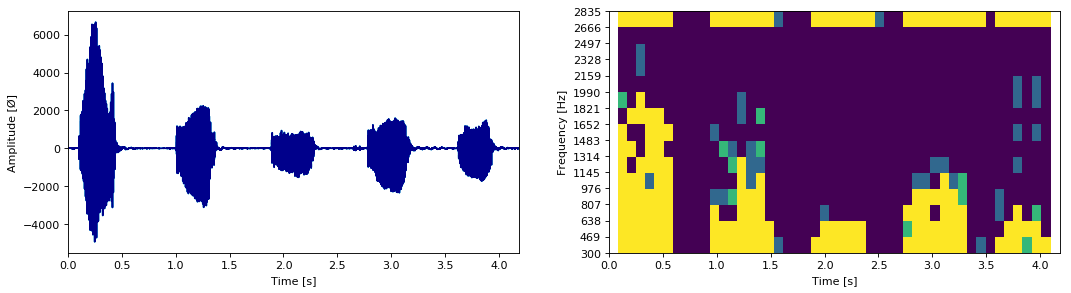

In [13]:
#!masquer

# Affichage du spectre d'amplitude
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Amplitude [Ø]")
ax[0].plot(t, y, color="aqua")
ax[0].plot(t, y, color="darkblue")
ax[0].set_xlim(0, time[-1]+time[0])

# Affichage du spectrogramme
ax[1].cla()
ax[1].set_ylabel("Frequency [Hz]")
ax[1].set_xlabel("Time [s]")
ax[1].set_yticks(np.arange(fmin, fmax, step))
ax[1].pcolormesh(time, rfreqs, rspectrum)
ax[1].set_xlim(0, time[-1]+time[0])
ax[1].plot()

# Affichage
plt.show()

# Etude des états

Afin de faciliter le traitement des données, il est possible de lire la valeur d'un retournée par l'état d'un filtre à un instant *t* donnée.

In [14]:
#!masquer

# Etats des filtres
#
# La fonction ci-dessous permet de détecter les zones de fréquences stimulées après l'application des différents filtres.
# - s : Temps (valeur comprise entre 0 et la durée du signal audio)
# - filter_no : Indice du filtre
#
# Elle retourne la liste des états sous forme numérique selon la résolution définie.
# - states : liste d'état (1 si la densité spectrale d'énergie était supérieure au seuil paramétré, 0 sinon)
def state_at(filter_no, s):
    # Calcul de l'indice dans la séquence
    i = 0
    while (i < len(time)) and (time[i] < s):
        i = i+1
    # Retourne l'état du filtre au temps spécifié
    return rspectrum[filter_no][i]

Par exemple, pour récupérer la valeur du filtre **10** à **t=0.01s** :

In [15]:
state_at(10, 0.01)

2.0